In [1]:
import pandas as pd, numpy as np, seaborn as sns
from pprint import pprint
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import math
from collections import Counter

import datetime, time

from pprint import pprint
import re

In [2]:
def printRuntime():
    print(datetime.datetime.now().strftime("%Y-%m-%d %T"))
    print("-"*19)
printRuntime()

2020-03-01 23:00:45
-------------------


# 1. Load data

In [3]:
basePath = "./kalapa/"
trainPath = basePath + "train.csv"
testPath = basePath + "test.csv"
colDesc = basePath + "column_description.csv"
sampleSubmit = basePath + "sample_submission.csv"

cleanedTrain = basePath + "cleanedTrain.pickle"
cleanedTest = basePath + "cleanedTest.pickle"
nb01 = basePath + "nb01.pickle"
nb02 = basePath + "nb02.pickle"
nb03 = basePath + "nb03.pickle"
printRuntime()

2020-03-01 23:00:45
-------------------


In [4]:
def avgAge(row):
    a = row["age_source1"]
    b = row["age_source2"]
    if np.isnan(a) and np.isnan(b):
        return np.nan
    elif np.isnan(a):
        return b
    elif np.isnan(b):
        return a
    else:
        return (a+b)/2.0
    
def diffAge(row):
    a = row["age_source1"]
    b = row["age_source2"]
    if np.isnan(a) and np.isnan(b):
        return np.nan
    elif np.isnan(a):
        return -b
    elif np.isnan(b):
        return a
    else:
        return (a+b)/2.0
    
def groupAge(age):
    # 18-23; 23-35; 35-50; 50+
    result = ""
    if np.isnan(age):
        result = "AGE_NONE"
    elif age <= 18:
        result = "AGE_0"
    elif age <=23:
        result = "AGE_1"
    elif age <=35:
        result = "AGE_2"
    elif age <= 50:
        result = "AGE_3"
    else:
        result = "AGE_4"
    return result
printRuntime()

2020-03-01 23:00:45
-------------------


# Train

In [5]:
pdfTrainRaw = pd.read_csv(trainPath)
printRuntime()

2020-03-01 23:00:46
-------------------


/Users/newuser/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
cond = (
    ~((pdfTrainRaw["age_source1"]<18) | (pdfTrainRaw["age_source2"]<18)) # Filter out age < 18, keep NaN
)
# pdfTrain = pdfTrainRaw[cond].copy()
pdfTrain = pdfTrainRaw.copy()
pdfTrain["maCv"] = pdfTrain["maCv"].apply(lambda x: str(x).lower())
pdfTrain["province"] = pdfTrain["province"].apply(lambda x: str(x).lower())
pdfTrain["district"] = pdfTrain["district"].apply(lambda x: str(x).lower())
print(pdfTrain.shape)
printRuntime()

(30000, 64)
2020-03-01 23:00:46
-------------------


In [7]:
lsMetaCol = ["id", "label", "province", "district", "age_source1", "age_source2", "maCv"]

# Test

In [8]:
pdfTestRaw = pd.read_csv(testPath)
printRuntime()

2020-03-01 23:00:47
-------------------


/Users/newuser/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
cond = (
    ~((pdfTestRaw["age_source1"]<18) | (pdfTestRaw["age_source2"]<18)) # Filter out age < 18, keep NaN
)
# pdfTest = pdfTestRaw[cond].copy()
pdfTest = pdfTestRaw.copy()
pdfTest["maCv"] = pdfTest["maCv"].apply(lambda x: str(x).lower())
pdfTest["province"] = pdfTest["province"].apply(lambda x: str(x).lower())
pdfTest["district"] = pdfTest["district"].apply(lambda x: str(x).lower())
print(pdfTest.shape)
printRuntime()

(20000, 63)
2020-03-01 23:00:47
-------------------


### Clean data

### Break down maCv to (maCv[:2] + maCv[2:])

In [11]:
def formatJob(iStr):
    if "none" == iStr or "nan" == iStr:
        return "none"
    # Replace all digit
    iStr = re.sub("\d", "", iStr)
    # Replace cn to cong nhan
    iStr = re.sub(r"^(cnhân|cn|coõng nhaõn)", "công nhân ", iStr)
    # Replace nv/nv. to nhan vien
    iStr = re.sub(r"(- nv|nv.|nv)", "nhân viên ", iStr)
    # Replace p. to phó
    iStr = re.sub(r"(^p\.)", "phó ", iStr)
    
    iStr = (iStr.replace("-", " ")
            .replace("cty", "công ty")
            .replace(".", " ")
            .replace("(", " ").
            replace(")", " ")
           )
    return iStr

def splitJobType(iStr):
    if "none" == iStr or "nan" == iStr:
        return "none", "none"
    iStr = formatJob(iStr)
    
    lsWord = iStr.split()
    if len(lsWord) == 0:
        return "none", "none"
    splitIdx = 2
    if "phó chánh" in iStr or ("phó trưởng" in iStr 
                               and "phó trưởng phòng" not in iStr
                               and "phó trưởng ban" not in iStr):
        splitIdx = 4
    elif ("phó phòng" not in iStr) and (lsWord[0] == "phó" or lsWord[0] == "trưởng"):
        splitIdx = 3
    
    jobCat = " ".join(lsWord[:splitIdx])
    jobDesc = "none"
    if len(lsWord) > splitIdx:
        jobDesc = " ".join(lsWord[splitIdx:])
    return jobCat, jobDesc

# Test
print(splitJobType("nhân viên phòng thí nghiệm"))
print(splitJobType("nhân viên bảo trì"))
print(splitJobType("cn ủi"))
print(splitJobType("9782cấp dưỡng"))
print(splitJobType("trưởng dây chuyền phòng sản xuất"))
print(splitJobType("p. trưởng phòng"))
printRuntime()

('nhân viên', 'phòng thí nghiệm')
('nhân viên', 'bảo trì')
('công nhân', 'ủi')
('cấp dưỡng', 'none')
('trưởng dây chuyền', 'phòng sản xuất')
('phó trưởng phòng', 'none')
2020-03-01 23:00:54
-------------------


In [12]:
# pdfTrain["jobCat"], pdfTrain["jobDesc"] = pdfTrain["maCv"].apply(lambda x: splitJobType(x))
%time
pdfTrain["maCv"] = pdfTrain["maCv"].apply(formatJob)
pdfTrain["maCv_vector"] = pdfTrain["maCv"].apply(lambda x: x.split())
pdfTrain["jobCat"], pdfTrain["jobDesc"] = zip(*pdfTrain["maCv"].apply(splitJobType))
printRuntime()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
2020-03-01 23:00:55
-------------------


In [13]:
# pdfTest["jobCat"], pdfTest["jobDesc"] = pdfTest["maCv"].apply(lambda x: splitJobType(x))
%time
pdfTest["maCv"] = pdfTest["maCv"].apply(formatJob)
pdfTest["maCv_vector"] = pdfTest["maCv"].apply(lambda x: x.split())
pdfTest["jobCat"], pdfTest["jobDesc"] = zip(*pdfTest["maCv"].apply(splitJobType))
printRuntime()

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.77 µs
2020-03-01 23:00:55
-------------------


In [14]:
pdfTrain = (pdfTrain
      .replace(np.nan, "None") # 'None' -> nan
      .replace("TRUE", True) # 'TRUE' -> True
      .replace("FALSE", False) # 'FALSE' -> False
     )

In [15]:
pdfTest = (pdfTest
      .replace(np.nan, "None") # 'None' -> nan
      .replace("TRUE", True) # 'TRUE' -> True
      .replace("FALSE", False) # 'FALSE' -> False
     )

In [16]:
pdfTrainBk = pdfTrain.copy()

pdfTestBk = pdfTest.copy()

#### Replace ilformed values by columns to safely remove

In [17]:
for dfTmp in [pdfTrain, pdfTest]:
    # 6
    dfTmp.loc[dfTmp["FIELD_6"]=="None", "FIELD_6"] = np.nan
    # dfTmp["FIELD_6"] = dfTmp["FIELD_6"] + 1
    
    # 12
    dfTmp.loc[~dfTmp["FIELD_12"].isin(["None", "0", "1"]), "FIELD_12"] = "None"

    # 35 'Four' 'One' 'Three' 'Two'
    dfTmp.loc[dfTmp["FIELD_35"]=="Zero", "FIELD_35"] = 1
    dfTmp.loc[dfTmp["FIELD_35"]=="One", "FIELD_35"] = 2
    dfTmp.loc[dfTmp["FIELD_35"]=="Two", "FIELD_35"] = 3
    dfTmp.loc[dfTmp["FIELD_35"]=="Three", "FIELD_35"] = 4
    dfTmp.loc[dfTmp["FIELD_35"]=="Four", "FIELD_35"] = 5
    
    # 40 
    dfTmp.loc[dfTmp["FIELD_40"].isin(["05 08 11 02", "08 02"]), "FIELD_40"] = "02 05 08 11"
    
    # 41 I II III IV V
    dfTmp.loc[dfTmp["FIELD_41"]=="I", "FIELD_41"] = 1
    dfTmp.loc[dfTmp["FIELD_41"]=="II", "FIELD_41"] = 2
    dfTmp.loc[dfTmp["FIELD_41"]=="III", "FIELD_41"] = 3
    dfTmp.loc[dfTmp["FIELD_41"]=="IV", "FIELD_41"] = 4
    dfTmp.loc[dfTmp["FIELD_41"]=="V", "FIELD_41"] = 5

    # 42
    dfTmp.loc[dfTmp["FIELD_42"]=="Zezo", "FIELD_42"] = 0
    dfTmp.loc[dfTmp["FIELD_42"]=="One", "FIELD_42"] = 1

    # 44
    dfTmp.loc[dfTmp["FIELD_44"]=="One", "FIELD_44"] = 1
    dfTmp.loc[dfTmp["FIELD_44"]=="Two", "FIELD_44"] = 2

    # 45
    dfTmp.loc[(dfTmp["FIELD_45"]=="1")|(dfTmp["FIELD_45"]==1.0), "FIELD_45"] = 1
    dfTmp.loc[(dfTmp["FIELD_45"]=="2")|(dfTmp["FIELD_45"]==2.0), "FIELD_45"] = 2

### One-hot 8 (gender), 10, 12, 17, 24, 40, 43

In [18]:
pdfTrainBk1 = pdfTrain.copy()
pdfTestBk1 = pdfTest.copy()

In [19]:
lsCol = [8, 10, 12, 17, 24, 40, 43]

In [20]:
# Get one hot encoding of columns for pdfTrain pdfTest
for d in lsCol:
    cName = "FIELD_%d" % d
    print(cName)
    one_hot = pd.get_dummies(pdfTrain[cName].replace(np.nan, "None"))
    renameCol = {}
    for c in one_hot.columns:
        renameCol[c] = "%s_%s" % (cName, c)
    # pprint(renameCol)
    one_hot = one_hot.rename(columns=renameCol)
#     pdfTrain = pdfTrain.drop(cName, axis = 1)
    # Join the encoded pdfTrain
    pdfTrain = pdfTrain.join(one_hot)

FIELD_8
FIELD_10
FIELD_12
FIELD_17
FIELD_24
FIELD_40
FIELD_43


In [21]:
for d in lsCol:
    cName = "FIELD_%d" % d
    print(cName)
    one_hot = pd.get_dummies(pdfTest[cName].replace(np.nan, "None"))
    renameCol = {}
    for c in one_hot.columns:
        renameCol[c] = "%s_%s" % (cName, c)
    # pprint(renameCol)
    one_hot = one_hot.rename(columns=renameCol)
#     pdfTest = pdfTest.drop(cName, axis = 1)
    # Join the encoded pdfTest
    pdfTest = pdfTest.join(one_hot)

FIELD_8
FIELD_10
FIELD_12
FIELD_17
FIELD_24
FIELD_40
FIELD_43


In [22]:
for d in lsCol:
    cName = "FIELD_%d" % d
    lsMissCol = [c for c in pdfTrain.columns if cName in c and c not in pdfTest.columns]
    for c in lsMissCol:
        print(cName)
        print("Add missing columns for test")        
        print(c)
        pdfTest[c] = 0

    lsRedCol = [c for c in pdfTest.columns if cName in c and c not in pdfTrain.columns]
    for c in lsRedCol:
        print("Remove redundant columns for test")
        print(c)
        pdfTest = pdfTest.drop(c, axis=1)

FIELD_17
Add missing columns for test
FIELD_17_G2
FIELD_40
Add missing columns for test
FIELD_40_4


In [23]:
print(pdfTrain.columns)

Index(['id', 'label', 'province', 'district', 'age_source1', 'age_source2',
       'maCv', 'FIELD_1', 'FIELD_2', 'FIELD_3',
       ...
       'FIELD_40_4', 'FIELD_40_6', 'FIELD_40_None', 'FIELD_43_0', 'FIELD_43_5',
       'FIELD_43_A', 'FIELD_43_B', 'FIELD_43_C', 'FIELD_43_D',
       'FIELD_43_None'],
      dtype='object', length=102)


In [146]:
"FIELD_43" in pdfTrain.columns

True

In [147]:
"FIELD_43" in pdfTest.columns

True

### Add FIELD_7_MOST, FIELD_7_LEN, FIELD_9_APPEAR, FIELD_9_INDEX

In [24]:
def mostFrequent(List): 
    occurenceCount = Counter(List) 
    lsCount = occurenceCount.most_common()
    maxAppear = lsCount[0][1]
    # print(lsCount)
    # print(maxAppear)
    lsVal = [v[0] for v in lsCount if v[1] == maxAppear]
    # Return list of most common items (if equally appeared)
    return lsVal

def mostAppear(iStr):
    if iStr == "[]" or iStr is np.nan:
        return "na"
    lsChar = iStr.replace("'", "").replace("[", "").replace("]", "").replace(" ", "").split(",")
    return mostFrequent(lsChar)

# Test
print(mostFrequent([2, 2, 3, 3, 3, 4, 5, 6])) # Expect [3]
print(mostAppear("['GD', 'GD', 'TE']")) # Expect ["GD"]

def index_7_9(row):
    """
    Return: (is_appear, index)
    """
    lsMostAppear7 = row["FIELD_7_MOST"]
    val9 = row["FIELD_9"]
    if val9 == "[]" or val9 == "na":
        return -2, -1
    elif lsMostAppear7 == "na":
        return -1, -1
    elif val9 in lsMostAppear7:
        return 1, lsMostAppear7.index(val9)
    else:
        # lsMostAppear7 is not null but 9 doesn't appear
        return 0, -1
    
printRuntime()

[3]
['GD']
2020-03-01 23:01:16
-------------------


In [25]:
# Add col as most appear FIELD_7
pdfTrain["FIELD_7_MOST"] = pdfTrain["FIELD_7"].apply(lambda x: mostAppear(x))
pdfTrain["FIELD_7_LEN"] = pdfTrain["FIELD_7_MOST"].apply(len)
# Add col as 9 appear in 7_MOST
pdfTrain["FIELD_9_APPEAR"], pdfTrain["FIELD_9_INDEX"] = zip(*pdfTrain.apply(lambda row: index_7_9(row), axis=1))

In [26]:
# Add col as most appear FIELD_7
pdfTest["FIELD_7_MOST"] = pdfTest["FIELD_7"].apply(lambda x: mostAppear(x))
pdfTest["FIELD_7_LEN"] = pdfTest["FIELD_7_MOST"].apply(len)
# Add col as 9 appear in 7_MOST
pdfTest["FIELD_9_APPEAR"], pdfTest["FIELD_9_INDEX"] = zip(*pdfTest.apply(lambda row: index_7_9(row), axis=1))

In [27]:
pdfTrain = pdfTrain.drop("FIELD_7_MOST", axis = 1)

pdfTest = pdfTest.drop("FIELD_7_MOST", axis = 1)

### Add avg_age, diff_age, group_age

In [28]:
pdfTrain.loc[pdfTrain["age_source1"]=="None", "age_source1"] = np.nan
pdfTrain.loc[pdfTrain["age_source2"]=="None", "age_source2"] = np.nan

In [29]:
pdfTrain["FIELD_avg_age"] = pdfTrain.apply(lambda row: avgAge(row), axis=1)
pdfTrain["FIELD_diff_age"] = pdfTrain.apply(lambda row: diffAge(row), axis=1)
pdfTrain["group_age"] = pdfTrain["FIELD_avg_age"].apply(lambda x: groupAge(x))
printRuntime()

2020-03-01 23:01:22
-------------------


In [30]:
pdfTest.loc[pdfTest["age_source1"]=="None", "age_source1"] = np.nan
pdfTest.loc[pdfTest["age_source2"]=="None", "age_source2"] = np.nan

In [31]:
pdfTest["FIELD_avg_age"] = pdfTest.apply(lambda row: avgAge(row), axis=1)
pdfTest["FIELD_diff_age"] = pdfTest.apply(lambda row: diffAge(row), axis=1)
pdfTest["group_age"] = pdfTest["FIELD_avg_age"].apply(lambda x: groupAge(x))
printRuntime()

2020-03-01 23:01:24
-------------------


### One hot group_age

In [32]:
cName = "group_age"
one_hot = pd.get_dummies(pdfTrain[cName].replace(np.nan, "None"))
renameCol = {}
for c in one_hot.columns:
    renameCol[c] = "FIELD_%s" % (c)
pprint(renameCol)
one_hot = one_hot.rename(columns=renameCol)

# pdfTrain = pdfTrain.drop(cName, axis = 1)
# Join the encoded pdfTrain
pdfTrain = pdfTrain.join(one_hot)
printRuntime()

{'AGE_0': 'FIELD_AGE_0',
 'AGE_1': 'FIELD_AGE_1',
 'AGE_2': 'FIELD_AGE_2',
 'AGE_3': 'FIELD_AGE_3',
 'AGE_4': 'FIELD_AGE_4',
 'AGE_NONE': 'FIELD_AGE_NONE'}
2020-03-01 23:01:24
-------------------


In [33]:
cName = "group_age"
one_hot = pd.get_dummies(pdfTest[cName].replace(np.nan, "None"))
renameCol = {}
for c in one_hot.columns:
    renameCol[c] = "FIELD_%s" % (c)
pprint(renameCol)
one_hot = one_hot.rename(columns=renameCol)

# pdfTest = pdfTest.drop(cName, axis = 1)
# Join the encoded pdfTest
pdfTest = pdfTest.join(one_hot)
printRuntime()

{'AGE_0': 'FIELD_AGE_0',
 'AGE_1': 'FIELD_AGE_1',
 'AGE_2': 'FIELD_AGE_2',
 'AGE_3': 'FIELD_AGE_3',
 'AGE_4': 'FIELD_AGE_4',
 'AGE_NONE': 'FIELD_AGE_NONE'}
2020-03-01 23:01:24
-------------------


In [34]:
pdfTrainBk2 = pdfTrain.copy()

pdfTestBk2 = pdfTest.copy()

### Add lv3_loc

In [35]:
pdfTrain["lv3_loc"] = "[" + pdfTrain["province"] + "]_[" + pdfTrain["district"] + "]"
lsProvince = pdfTrain["province"].unique()
lsLoc = pdfTrain["lv3_loc"].unique()
print(len(lsProvince), len(lsLoc))
printRuntime()

65 766
2020-03-01 23:01:30
-------------------


In [36]:
pdfTest["lv3_loc"] = "[" + pdfTest["province"] + "]_[" + pdfTest["district"] + "]"
lsProvince = pdfTest["province"].unique()
lsLoc = pdfTest["lv3_loc"].unique()
print(len(lsProvince), len(lsLoc))
printRuntime()

65 724
2020-03-01 23:01:31
-------------------


### Convert data types

In [37]:
lsExtraFt = (["FIELD_7_LEN", "FIELD_9_APPEAR", "FIELD_9_INDEX"]  + ["avg_age", "diff_age"]
             )

In [38]:
lsFieldFt = ([c for c in pdfTrain.columns 
              if "FIELD" in c 
              and c not in ["FIELD_%d"%d for d in [7, 9, 13, 39]]] 
#              + lsExtraFt
            )
# pprint(lsFieldFt)
printRuntime()

2020-03-01 23:01:35
-------------------


In [39]:
lsFieldFtTest = ([c for c in pdfTest.columns 
                  if "FIELD" in c 
                  and c not in ["FIELD_%d"%d for d in [7, 9, 13, 39]]]
#                  + lsExtraFt
                )
print(sorted(lsFieldFtTest) == sorted(lsFieldFt))
printRuntime()

True
2020-03-01 23:01:37
-------------------


In [40]:
lsFieldFt

['FIELD_1',
 'FIELD_2',
 'FIELD_3',
 'FIELD_4',
 'FIELD_5',
 'FIELD_6',
 'FIELD_8',
 'FIELD_10',
 'FIELD_11',
 'FIELD_12',
 'FIELD_14',
 'FIELD_15',
 'FIELD_16',
 'FIELD_17',
 'FIELD_18',
 'FIELD_19',
 'FIELD_20',
 'FIELD_21',
 'FIELD_22',
 'FIELD_23',
 'FIELD_24',
 'FIELD_25',
 'FIELD_26',
 'FIELD_27',
 'FIELD_28',
 'FIELD_29',
 'FIELD_30',
 'FIELD_31',
 'FIELD_32',
 'FIELD_33',
 'FIELD_34',
 'FIELD_35',
 'FIELD_36',
 'FIELD_37',
 'FIELD_38',
 'FIELD_40',
 'FIELD_41',
 'FIELD_42',
 'FIELD_43',
 'FIELD_44',
 'FIELD_45',
 'FIELD_46',
 'FIELD_47',
 'FIELD_48',
 'FIELD_49',
 'FIELD_50',
 'FIELD_51',
 'FIELD_52',
 'FIELD_53',
 'FIELD_54',
 'FIELD_55',
 'FIELD_56',
 'FIELD_57',
 'FIELD_8_FEMALE',
 'FIELD_8_MALE',
 'FIELD_8_None',
 'FIELD_10_GH',
 'FIELD_10_None',
 'FIELD_10_T1',
 'FIELD_12_0',
 'FIELD_12_1',
 'FIELD_12_None',
 'FIELD_17_G2',
 'FIELD_17_G3',
 'FIELD_17_G4',
 'FIELD_17_G7',
 'FIELD_17_G8',
 'FIELD_17_G9',
 'FIELD_17_GX',
 'FIELD_17_None',
 'FIELD_24_K1',
 'FIELD_24_K2',
 'FIE

In [41]:
for c in lsFieldFt:
    try:
        pdfTrain.loc[pdfTrain[c].isin(["None", "na"]), c] = np.nan
        pdfTrain[c] = pdfTrain[c].astype(np.float64)
        pdfTest.loc[pdfTest[c].isin(["None", "na"]), c] = np.nan
        pdfTest[c] = pdfTest[c].astype(np.float64)
    except:
        print(c)
printRuntime()

FIELD_8
FIELD_10
FIELD_17
FIELD_24
FIELD_40
FIELD_43
2020-03-01 23:01:53
-------------------


In [ ]:
# 2
lsCatCol = ["FIELD_%d"%d for d in [8, 10, 17, 24, 40, 43]]
lsNumCol = [c for c in lsFieldFt if c not in lsCatCol]

## Cluster test, use predicted cluster in train & test, add as 1-hot features

In [91]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
#from sklearn.impute import SimpleImputer

In [92]:
pdfTrainFillna = pdfTrain.replace([np.inf, -np.inf], np.nan).fillna(0.0)
pdfTestFillna = pdfTest.replace([np.inf, -np.inf], np.nan).fillna(0.0)
printRuntime()

2020-03-01 23:36:48
-------------------


In [94]:
X = pdfTrainFillna[lsNumCol].values
Y = pdfTestFillna[lsNumCol].values
scaler = MinMaxScaler()
Y_scaled = scaler.fit_transform(Y)
X_scaled = scaler.transform(X) # Use scaler by Y
printRuntime()

2020-03-01 23:37:56
-------------------


In [95]:
ky_15 = KMeans(n_clusters=15).fit(Y_scaled)

In [96]:
X_cluster = ky_15.predict(X_scaled)

In [97]:
Y_cluster = ky_15.predict(Y_scaled)

In [98]:
X_cluster.shape, Y_cluster.shape

((30000,), (20000,))

In [99]:
pdfTrain["kmean_cluster"] = X_cluster
pdfTest["kmean_cluster"] = Y_cluster

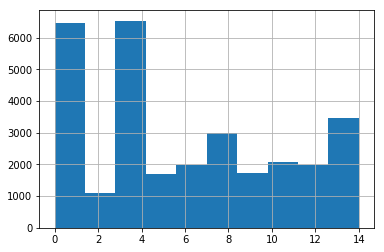

In [100]:
pdfTrain["kmean_cluster"].hist()

In [108]:
pdfB = (pdfTrain.groupby(["kmean_cluster", "jobCat"], as_index=False)
        .agg({"id": "count", "label":("sum", "mean")})
       )
pdfB.head(20)

kmean_cluster           jobCat    id label          
                                  count   sum      mean
0              0           bác sĩ     1     0  0.000000
1              0          bảo mẫu     1     0  0.000000
2              0           bảo vệ     5     0  0.000000
3              0       bếp trưởng     1     0  0.000000
4              0      chuyên viên     7     1  0.142857
5              0       chuyền may     1     0  0.000000
6              0          chỉ huy     1     0  0.000000
7              0              cod     2     0  0.000000
8              0           cán bộ     8     0  0.000000
9              0          công an     1     0  0.000000
10             0        công chức     1     0  0.000000
11             0        công nhân   383     4  0.010444
12             0  công nhân_chuẩn     1     0  0.000000
13             0       cửa hàng     1     0  0.000000
14             0        cấp dưỡng     2     0  0.000000
15             0        cụng nhõn     1     0  0.000000
16             0         giám sát     2     0  0.000000
17             0         giám đốc     2     0  0.000000
18             0        giáo viên    27     0  0.000000
19             0        gíao viên     1     0  0.000000

In [105]:
pdfA = (pdfTrain.groupby(["kmean_cluster", "label"], as_index=False).agg({"id": "count"})
        .pivot(index="kmean_cluster", columns="label", values="id").rename_axis(None)
       )
pdfA["ratio"] = pdfA[1]/pdfA[0]
pdfA.sort_values(["ratio"])

label,0,1,ratio
14,1803,12,0.006656
3,1563,13,0.008317
12,1970,17,0.008629
8,1620,16,0.009877
5,1667,17,0.010198
0,1730,18,0.010405
9,1701,18,0.010582
13,1612,26,0.016129
7,1321,25,0.018925
4,4863,93,0.019124


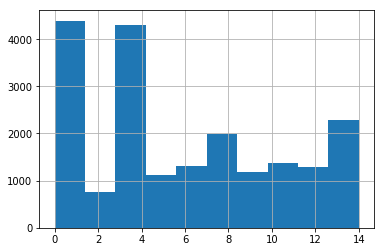

In [101]:
pdfTest["kmean_cluster"].hist()

In [110]:
# 1 hot kmean_cluster columns
cName = "kmean_cluster"
# -- Train -- #
one_hot = pd.get_dummies(pdfTrain[cName].replace(np.nan, "None"))
renameCol = {}
for c in one_hot.columns:
    renameCol[c] = "FIELD_KMeans_%s" % (c)
pprint(renameCol)
one_hot = one_hot.rename(columns=renameCol)
pdfTrain = pdfTrain.join(one_hot)

# -- Test -- #
one_hot = pd.get_dummies(pdfTest[cName].replace(np.nan, "None"))
renameCol = {}
for c in one_hot.columns:
    renameCol[c] = "FIELD_KMeans_%s" % (c)
# pprint(renameCol)
one_hot = one_hot.rename(columns=renameCol)
pdfTest = pdfTest.join(one_hot)

printRuntime()

{0: 'FIELD_KMeans_0',
 1: 'FIELD_KMeans_1',
 2: 'FIELD_KMeans_2',
 3: 'FIELD_KMeans_3',
 4: 'FIELD_KMeans_4',
 5: 'FIELD_KMeans_5',
 6: 'FIELD_KMeans_6',
 7: 'FIELD_KMeans_7',
 8: 'FIELD_KMeans_8',
 9: 'FIELD_KMeans_9',
 10: 'FIELD_KMeans_10',
 11: 'FIELD_KMeans_11',
 12: 'FIELD_KMeans_12',
 13: 'FIELD_KMeans_13',
 14: 'FIELD_KMeans_14'}
2020-03-01 23:52:19
-------------------


In [111]:
lsKMeansFt = [c for c in pdfTrain.columns if "KMeans" in c]
for c in lsKMeansFt:
    print(pdfTrain[c].dtypes)

uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


### Add neighbor features
Neighbor features: 
    + avg+std of groupby (province, age_group, maCv)
    + avg+std of groupby (lv3_loc, age_group, maCv)
    + avg+std of groupby (province, maCv)
    

In [119]:
lsExtraFt = (["FIELD_7_LEN", "FIELD_9_APPEAR", "FIELD_9_INDEX"]  + ["avg_age", "diff_age"]
             )

In [120]:
lsFieldFt = ([c for c in pdfTrain.columns 
              if "FIELD" in c 
              and c not in ["FIELD_%d"%d for d in [7, 9, 13, 39]]] 
#              + lsExtraFt
            )
# pprint(lsFieldFt)
printRuntime()

2020-03-01 23:56:54
-------------------


In [121]:
lsFieldFtTest = ([c for c in pdfTest.columns 
                  if "FIELD" in c 
                  and c not in ["FIELD_%d"%d for d in [7, 9, 13, 39]]]
#                  + lsExtraFt
                )
print(sorted(lsFieldFtTest) == sorted(lsFieldFt))
printRuntime()

True
2020-03-01 23:56:58
-------------------


In [123]:
# 1
lsMetaCol1 = ["province", "group_age", "jobCat"]
lsMetaCol2 = ["lv3_loc", "group_age", "jobCat"]
lsMetaCol3 = ["province", "jobCat"]
# 2
lsCatCol = ["FIELD_%d"%d for d in [8, 10, 17, 24, 40, 43]]
lsNumCol = [c for c in lsFieldFt if c not in lsCatCol]

In [124]:
len(lsNumCol) # 92 vs. 108

108

In [125]:
aggDict = {}
for f in lsNumCol:
    aggDict[f] = ["mean", "std"]

In [126]:
dfNb01 = pdfTrain[lsMetaCol1+lsNumCol].groupby(lsMetaCol1, as_index=False).agg(aggDict)
dfNb01.columns = ["_".join(x) for x in dfNb01.columns.ravel()]
dfNb01 = dfNb01.rename(columns={"province_": "province", 
                       "group_age_": "group_age", 
                       "jobCat_": "jobCat"})
printRuntime()

2020-03-01 23:57:33
-------------------


In [127]:
dfNb02 = pdfTrain[lsMetaCol2+lsNumCol].groupby(lsMetaCol2, as_index=False).agg(aggDict)
dfNb02.columns = ["_".join(x) for x in dfNb02.columns.ravel()]
dfNb02 = dfNb02.rename(columns={"province_": "province", 
                       "group_age_": "group_age", 
                       "jobCat_": "jobCat"})
printRuntime()

2020-03-01 23:57:35
-------------------


In [128]:
dfNb03 = pdfTrain[lsMetaCol3+lsNumCol].groupby(lsMetaCol3, as_index=False).agg(aggDict)
dfNb03.columns = ["_".join(x) for x in dfNb03.columns.ravel()]
dfNb03 = dfNb03.rename(columns={"province_": "province", 
                       "group_age_": "group_age", 
                       "jobCat_": "jobCat"})
printRuntime()

2020-03-01 23:57:36
-------------------


### raw ft + nb ft + standardize raw ft

In [129]:
lsMetaCol = ["id", "label", "province", "district", "lv3_loc", 
              "age_source1", "age_source2", "avg_age", "diff_age", "group_age",
              "maCv", "jobCat", "jobDesc"]
lsEmbedFt = ["FIELD_%d"%d for d in [7, 9, 13, 39]]
lsCol = [8, 10, 12, 17, 24, 40, 43] # For target encoding
lsCatCol = ["FIELD_%d"%d for d in lsCol] + ["group_age", "kmean_cluster"]
# raw ft
lsFieldFt = ([c for c in pdfTrain.columns 
             if "FIELD" in c 
             and c not in lsEmbedFt and c not in lsCatCol]
            )

label = "label"
printRuntime()

2020-03-01 23:58:06
-------------------


#### NB Ft1: province, group_age, jobCat

In [130]:
# nb ft
print("Merge nb01")
lsNbMetaCol = lsMetaCol1
dfNb = dfNb01 

dfITrain = pd.merge(pdfTrain, dfNb01, on=lsNbMetaCol, how="left")

print(dfITrain.shape)
printRuntime()

Merge nb01
(30000, 347)
2020-03-01 23:58:10
-------------------


In [131]:
lsTmp = [c for c in dfITrain.columns if c not in lsFieldFt]
# pprint(lsTmp)

In [177]:
dfITrain.columns

Index(['id', 'label', 'province', 'district', 'age_source1', 'age_source2',
       'maCv', 'FIELD_1', 'FIELD_2', 'FIELD_3',
       ...
       'FIELD_AGE_3_mean', 'FIELD_AGE_3_std', 'FIELD_AGE_4_mean',
       'FIELD_AGE_4_std', 'FIELD_AGE_NONE_mean', 'FIELD_AGE_NONE_std',
       'FIELD_group_age_ecdmean_mean', 'FIELD_group_age_ecdmean_std',
       'FIELD_group_age_ecdstd_mean', 'FIELD_group_age_ecdstd_std'],
      dtype='object', length=331)

In [178]:
dfITrain.head()

,id,label,province,district,age_source1,age_source2,maCv,FIELD_1,FIELD_2,FIELD_3,...,FIELD_AGE_3_mean,FIELD_AGE_3_std,FIELD_AGE_4_mean,FIELD_AGE_4_std,FIELD_AGE_NONE_mean,FIELD_AGE_NONE_std,FIELD_group_age_ecdmean_mean,FIELD_group_age_ecdmean_std,FIELD_group_age_ecdstd_mean,FIELD_group_age_ecdstd_std
0,0,0,nan,nan,NaN,NaN,none,1.0,1.0,2547.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.019980,0.0,0.139941,0.0
1,1,0,tỉnh đồng nai,thành phố biên hòa,44,44,none,1.0,0.0,-1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.016651,0.0,0.127971,0.0
2,2,0,tỉnh đồng nai,huyện long thành,30,30,công nhân,0.0,1.0,3273.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.013346,0.0,0.114758,0.0
3,3,0,tỉnh tuyên quang,thành phố tuyên quang,43,NaN,none,0.0,1.0,3991.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.016651,0.0,0.127971,0.0
4,4,0,thành phố hồ chí minh,quận 1,21,21,none,0.0,1.0,1450.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.014498,0.0,0.119550,0.0


In [132]:
for c in lsFieldFt:
    dfITrain["%s_stdized1"%c] = (dfITrain[c] - dfITrain[c+"_mean"])/dfITrain[c+"_std"]
print(dfITrain.shape) # (29924, 353)
printRuntime()

(30000, 454)
2020-03-01 23:58:17
-------------------


In [134]:
lsNb01Ft

['FIELD_1_mean',
 'FIELD_1_std',
 'FIELD_2_mean',
 'FIELD_2_std',
 'FIELD_3_mean',
 'FIELD_3_std',
 'FIELD_4_mean',
 'FIELD_4_std',
 'FIELD_5_mean',
 'FIELD_5_std',
 'FIELD_6_mean',
 'FIELD_6_std',
 'FIELD_11_mean',
 'FIELD_11_std',
 'FIELD_12_mean',
 'FIELD_12_std',
 'FIELD_14_mean',
 'FIELD_14_std',
 'FIELD_15_mean',
 'FIELD_15_std',
 'FIELD_16_mean',
 'FIELD_16_std',
 'FIELD_18_mean',
 'FIELD_18_std',
 'FIELD_19_mean',
 'FIELD_19_std',
 'FIELD_20_mean',
 'FIELD_20_std',
 'FIELD_21_mean',
 'FIELD_21_std',
 'FIELD_22_mean',
 'FIELD_22_std',
 'FIELD_23_mean',
 'FIELD_23_std',
 'FIELD_25_mean',
 'FIELD_25_std',
 'FIELD_26_mean',
 'FIELD_26_std',
 'FIELD_27_mean',
 'FIELD_27_std',
 'FIELD_28_mean',
 'FIELD_28_std',
 'FIELD_29_mean',
 'FIELD_29_std',
 'FIELD_30_mean',
 'FIELD_30_std',
 'FIELD_31_mean',
 'FIELD_31_std',
 'FIELD_32_mean',
 'FIELD_32_std',
 'FIELD_33_mean',
 'FIELD_33_std',
 'FIELD_34_mean',
 'FIELD_34_std',
 'FIELD_35_mean',
 'FIELD_35_std',
 'FIELD_36_mean',
 'FIELD_36_std

In [133]:
print("Drop nb01 group ft (mean, std)")
lsNb01Ft = [c for c in dfNb01.columns if "FIELD" in c]
print("%d columns"%len(lsNb01Ft))
dfITrain = dfITrain.drop(lsNb01Ft, axis=1)
print(dfITrain.shape)
printRuntime()

Drop nb01 group ft (mean, std)
216 columns
(30000, 238)
2020-03-01 23:58:19
-------------------


#### NB Ft3: province, group_age, jobCat

In [135]:
# nb ft
lsNbMetaCol = lsMetaCol3
dfNb = dfNb03
printRuntime()

2020-03-01 23:59:07
-------------------


In [136]:
print("Pre-merge shape:", dfITrain.shape)
dfITrain = pd.merge(dfITrain, dfNb, on=lsNbMetaCol, how="left")

print("Post-merge shape:", dfITrain.shape)
printRuntime()

Pre-merge shape: (30000, 238)
Post-merge shape: (30000, 454)
2020-03-01 23:59:10
-------------------


In [137]:
for c in lsFieldFt:
    dfITrain["%s_stdized2"%c] = (dfITrain[c] - dfITrain[c+"_mean"])/dfITrain[c+"_std"]
print(dfITrain.shape) # (29924, 353)
printRuntime()

(30000, 561)
2020-03-01 23:59:14
-------------------


In [138]:
print("Drop nb03 group ft (mean, std)")
lsNb03Ft = [c for c in dfNb03.columns if "FIELD" in c]
print("%d columns"%len(lsNb03Ft))
dfITrain = dfITrain.drop(lsNb03Ft, axis=1)
print(dfITrain.shape)
printRuntime()

Drop nb03 group ft (mean, std)
216 columns
(30000, 345)
2020-03-01 23:59:17
-------------------


### Save iTrain data

In [139]:
ymd = datetime.datetime.now().strftime("%Y%m%d")
iTrainPath = basePath + "itrain_{}.pickle".format(ymd)
print(iTrainPath)
dfITrain.to_pickle(iTrainPath, compression="bz2")
printRuntime()

./kalapa/itrain_20200301.pickle
2020-03-01 23:59:32
-------------------


In [181]:
dfITrain.head()

,id,label,province,district,age_source1,age_source2,maCv,FIELD_1,FIELD_2,FIELD_3,...,FIELD_9_APPEAR_stdized,FIELD_9_INDEX_stdized,FIELD_avg_age_stdized,FIELD_diff_age_stdized,FIELD_AGE_0_stdized,FIELD_AGE_1_stdized,FIELD_AGE_2_stdized,FIELD_AGE_3_stdized,FIELD_AGE_4_stdized,FIELD_AGE_NONE_stdized
0,0,0,nan,nan,NaN,NaN,none,1.0,1.0,2547.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,tỉnh đồng nai,thành phố biên hòa,44,44,none,1.0,0.0,-1.0,...,0.637609,0.193968,0.228218,0.228218,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,tỉnh đồng nai,huyện long thành,30,30,công nhân,0.0,1.0,3273.0,...,0.664303,0.202861,0.150470,0.150470,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,tỉnh tuyên quang,thành phố tuyên quang,43,NaN,none,0.0,1.0,3991.0,...,-1.306296,-0.957427,0.593771,0.593771,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,thành phố hồ chí minh,quận 1,21,21,none,0.0,1.0,1450.0,...,0.591361,1.803420,-0.710923,-0.710923,NaN,NaN,NaN,NaN,NaN,NaN


# Prepare itest

In [140]:
print("Merge nb01")
lsNbMetaCol = lsMetaCol1
dfNb = dfNb01
dfITest = pd.merge(pdfTest, dfNb, on=lsNbMetaCol, how="left")

dfITest.shape # label col is missing

lsTmp = [c for c in dfITest.columns if c not in lsFieldFt]
# pprint(lsTmp)

Merge nb01


In [187]:
dfITest.head()

,id,province,district,age_source1,age_source2,maCv,FIELD_1,FIELD_2,FIELD_3,FIELD_4,...,FIELD_AGE_3_mean,FIELD_AGE_3_std,FIELD_AGE_4_mean,FIELD_AGE_4_std,FIELD_AGE_NONE_mean,FIELD_AGE_NONE_std,FIELD_group_age_ecdmean_mean,FIELD_group_age_ecdmean_std,FIELD_group_age_ecdstd_mean,FIELD_group_age_ecdstd_std
0,30000,nan,nan,NaN,NaN,none,1.0,1.0,719.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.019980,0.0,0.139941,0.0
1,30001,nan,nan,NaN,NaN,none,1.0,1.0,1442.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.019980,0.0,0.139941,0.0
2,30002,thành phố hà nội,huyện mỹ đức,32,32,trưởng dây chuyền phòng sản xuất,0.0,1.0,4000.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30003,nan,nan,NaN,25,none,0.0,1.0,1073.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.013346,0.0,0.114758,0.0
4,30004,nan,nan,NaN,NaN,none,1.0,1.0,703.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.019980,0.0,0.139941,0.0


In [141]:
for c in lsFieldFt:
    # stdized1 and stdized3
    dfITest["%s_stdized1"%c] = (dfITest[c] - dfITest[c+"_mean"])/dfITest[c+"_std"]
print(dfITest.shape) # (19936, 340)
printRuntime()

(20000, 453)
2020-03-01 23:59:48
-------------------


In [142]:
print("Drop nb01 group ft (mean, std)")
lsNb01Ft = [c for c in dfNb01.columns if "FIELD" in c]
dfITest = dfITest.drop(lsNb01Ft, axis=1)
print(dfITest.shape)
printRuntime()

Drop nb01 group ft (mean, std)
(20000, 237)
2020-03-01 23:59:50
-------------------


#### NB Ft3: province, group_age, jobCat

In [143]:
# nb ft
print("Merge nb03")
lsNbMetaCol = lsMetaCol3
dfNb = dfNb03

print("Pre-merge shape:", dfITest.shape)
dfITest = pd.merge(dfITest, dfNb, on=lsNbMetaCol, how="left")

print("Post-merge shape:", dfITest.shape)
printRuntime()

Merge nb03
Pre-merge shape: (20000, 237)
Post-merge shape: (20000, 453)
2020-03-01 23:59:53
-------------------


In [144]:
for c in lsFieldFt:
    dfITest["%s_stdized2"%c] = (dfITest[c] - dfITest[c+"_mean"])/dfITest[c+"_std"]
print(dfITest.shape) # (29924, 353)
printRuntime()

(20000, 560)
2020-03-01 23:59:58
-------------------


In [145]:
print("Drop nb03 group ft (mean, std)")
lsNb03Ft = [c for c in dfNb03.columns if "FIELD" in c]
dfITest = dfITest.drop(lsNb03Ft, axis=1)
print(dfITest.shape)
printRuntime()

Drop nb03 group ft (mean, std)
(20000, 344)
2020-03-02 00:00:00
-------------------


### Save iTest data

In [146]:
dfITrain.shape, dfITest.shape

((30000, 345), (20000, 344))

In [147]:
iTestPath = basePath + "itest_{}.pickle".format(ymd)
dfITest.to_pickle(iTestPath, compression="bz2")
printRuntime()

2020-03-02 00:00:33
-------------------
